# Neural circuit dynamics underlying accumulatoin of time-varing evidence during perceptual decision making
Wong, Huk, Shadlen, Wang
Frontiers in Computational Neuroscience, November 2007, Volume 1, Article 6

## Material and Methods
### The two-variable network model

### Calling Library Fuctions

In [1]:
# LIBRARY

import numpy as np # vector manipulation
import math  # math functions
import sys

# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")


### Time Scale
THe data are simulated over a 2500 ms window from $-500$ms prior to Target 

In [2]:
h=1/1000

time=np.arange(-500,2000.01,h*1000)

### The Reduced Network Model

$$r_i=f(I_i)=\frac{aI_i-b}{1-exp[-d(aI_i-b])}$$

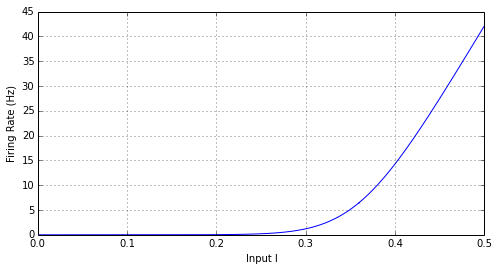

In [3]:
def Reduced_Network_Firing(I):
    a=300 # Hz/nA
    b=108 # Hz
    d=0.154 # seconds
    f=(a*I-b)/(1-np.exp(-d*(a*I-b)))
    return f

I=np.arange(0,0.5,0.0001)
fig = plt.figure(figsize=(8,4))
plt.plot(I,Reduced_Network_Firing(I),'-',color='blue',label='Noise_L')
plt.grid()
plt.xlabel('Input I')
plt.ylabel('Firing Rate (Hz)')
plt.show()

### Neural Circuit
$$ I_{L,tot}=J_{LL}S_L-J_{LR}S_R+I_{motion,L}+I_{target}+I_{noise,L}$$
$$ I_{R,tot}=J_{RR}S_R-J_{RL}S_L+I_{motion,R}+I_{target}+I_{noise,R}$$

where the synaptic couplings are $J_{LL}=0.3725$, $J_{RR}=0.3725$, $J_{LR}=0.1137$ and $J_{RL}=0.1137$.
$I_{motion,L}$ represents the random dots stimulus 


In [4]:
def total_synaptic_current(S_L,S_R,I_motion_L,I_motion_R,I_target,I_noise_L,I_noise_R):
    # Synaptic coupling
    J_LL=0.3725 # nA
    J_RR=0.3725 # nA
    J_LR=0.1137 # nA
    J_RL=0.1137 # nA

    I_L_tot=J_LL*S_L-J_LR*S_R+I_motion_L+I_target+I_noise_L
    I_R_tot=J_RR*S_R-J_RL*S_L+I_motion_R+I_target+I_noise_R
    return I_L_tot, I_R_tot


### Background activity
$$ \tau_{noise}\frac{d I_{noise,i}(t)}{dt} =-(I_{noise,i}(t)-I_0)+\eta_i(t)\sqrt{\tau_{noise}}\sigma_{noise}$$
with a mean backgroud input $I_0=0.3297$, white noise $\eta(t_j)$ noise amplitude $\sigma_{noise}=0.009$ nA and fitler time constant $\tau_{noise}=2$ms.
The solution to the equation is approximated used the forward Euler method giving the difference equation
$$ I_{noise,j+1}=I_{noise,j}+\frac{h}{\tau_{noise}}(-(I_{noise,j}-I_0)+\eta_{j}\sqrt{\tau_{noise}}\sigma_{noise} $$
where $h$ is the time step.

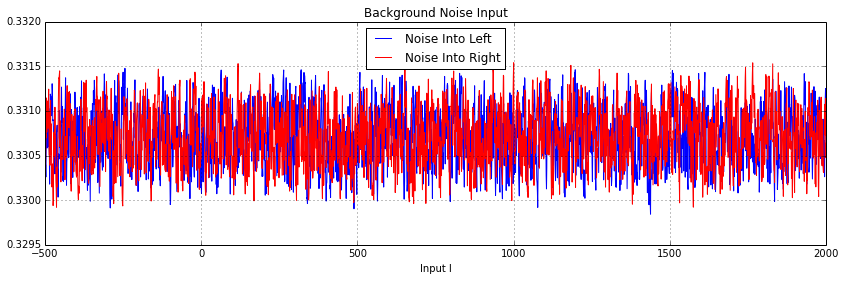

In [5]:
def Background_Activity(I_noise,h):
    I_0=0.3297 #nA
    sigma_noise=0.009 # nA
    tau_noise=2/1000 #ms
    eta_noise=np.random.random(1)*5
    I_noise_new=I_noise+h/tau_noise*(-(I_noise-I_0)+eta_noise*np.sqrt(tau_noise)*sigma_noise)
    return I_noise_new

I_noise_L=0.3297*np.ones(len(time))
I_noise_R=0.3297*np.ones(len(time))
for i in range (0,len(time)-1):
    I_noise_L[i+1]=Background_Activity(I_noise_L[i],h)
    I_noise_R[i+1]=Background_Activity(I_noise_R[i],h)
  
fig = plt.figure(figsize=(14,4))
plt.plot(time,I_noise_L,'-',color='blue',label='Noise Into Left')
plt.plot(time,I_noise_R,'-',color='red',label='Noise Into Right')
plt.grid()
plt.legend(loc='Best')
plt.xlabel('Input I')
plt.title('Background Noise Input')
plt.xlim((-500,2000))
plt.show()

### Network Dynamics
The network dynamics is dominated by $S_i$ model by the first order problem:
$$ \frac{d S_{i}}{dt} =-\frac{S_{i}}{\tau_S}+(1-S_{i})\gamma f(I)$$
where $\gamma=0.641$ and $\tau_s=60$ms. 
The solution to the equation is approximated used the forward Euler method giving the difference equation
$$ S_{i,j+1}=S_{i,j}+h\left(-\frac{S_{i,j}}{\tau_S}+(1-S_{i,j}\gamma f(I_i) \right)$$
where $h$ is the time step.

In [6]:
def Network_Dynamics(S,I,h):
    gamma=0.641
    tau_S=60/1000 #ms
    S_new=S+h*(-S/tau_S+(1-S)*gamma*Reduced_Network_Firing(I))
    return S_new

### Input Motion
The inpute current due to random dot coherence is:
$$ I_{motion,i}=J_{A,ext} \mu_0 \left( 1+f_{gain}\frac{c'\pm p}{100\%} \right) $$
where $c'$ is the motion coherence, $J_{A,ext}=0.00011$nA/Hz and the $\pm$ refers to the neural population for which the motion stimulus is the prefered or null direction. $f_{gain}$ is the gain of MT firing rates on either prefered or null direction is chosen to be $0.45$. The pooled MT neuronal response to zero motion coherence is $\mu_0=30$. 

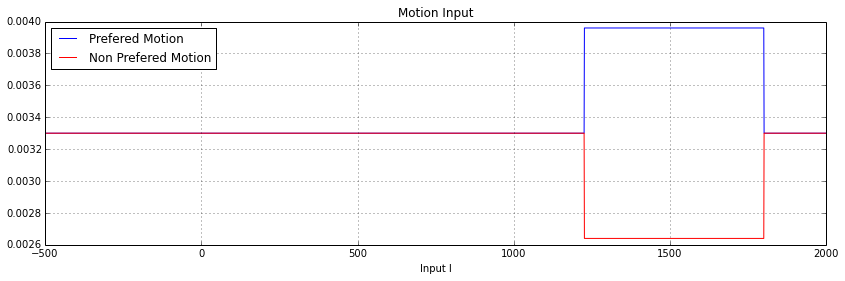

In [7]:
def I_motion_function(c_dash):
    J_A_ext=0.00011 # nA/Hz
    mu_0=30 # Hz
    f_pref=1
    p=0
    I_motion=J_A_ext*mu_0*(1+f_pref*(p+c_dash)/100)
    return I_motion


I_motion_L=0.0*time # np.zeros((1,len(time)))
I_motion_R=0.0*time # np.zeros((1,len(time)))
for i in range (0,len(time)):
    if time[i] >1225 and time[i] <=1800:
        c_dash=20
    else:
        c_dash=0
    I_motion_L[i]=I_motion_function(c_dash)
    I_motion_R[i]=I_motion_function(-c_dash)
    
fig = plt.figure(figsize=(14,4))
plt.plot(time,I_motion_L,'-',color='blue',label='Prefered Motion')
plt.plot(time,I_motion_R,'-',color='red',label='Non Prefered Motion')
plt.grid()
plt.legend(loc='Best')
plt.xlabel('Input I')
plt.title('Motion Input')
plt.xlim((-500,2000))
plt.show()

### Input Current Target




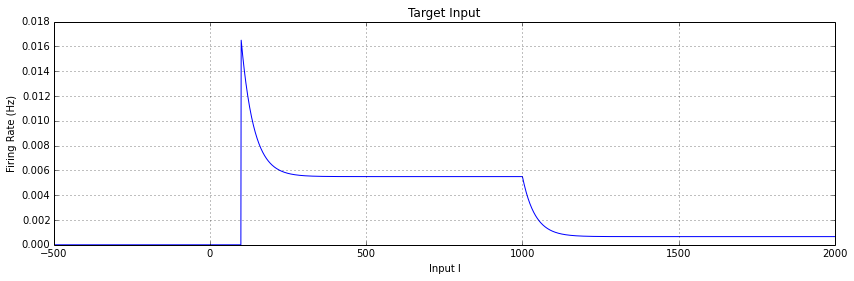

In [8]:
def I_target_function(time):
    tau_ad=40 # ms
    J_A_ext=0.00011 # nA/Hz
    t_target=100
    t_motion=1000
    if time < t_target:
        I_target=0
    elif (time >=t_target) and (time< t_motion):
        I_target=J_A_ext*(50+100*np.exp(-(time-t_target)/tau_ad))
    else:
        I_target=J_A_ext*(6+44*np.exp(-(time-t_motion)/tau_ad))
    return I_target

I_target=np.zeros(len(time))
for i in range (0,len(time)):
    I_target[i]=I_target_function(time[i])

    
fig = plt.figure(figsize=(14,4))
plt.plot(time,I_target,'-',color='blue',label='Noise_L')
plt.grid()
plt.xlabel('Input I')
plt.ylabel('Firing Rate (Hz)')
plt.title('Target Input')
plt.xlim(-500,2000)
plt.show()

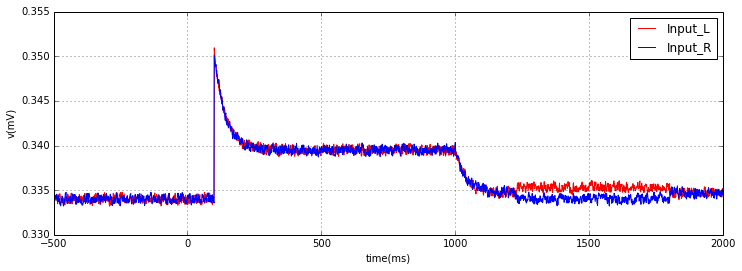

In [9]:
S_L=0.00*np.ones(len(time))
S_R=0.00*np.ones(len(time))
I_L_tot=np.ones(len(time))
I_R_tot=np.ones(len(time))


I_L_tot ,I_R_tot=total_synaptic_current(S_L,S_R,
                                        I_motion_L,I_motion_R,
                                        I_target,
                                        I_noise_L,I_noise_R)

I_L_tot[0] ,I_R_tot[0]=total_synaptic_current(S_L[0],S_R[0],
                                              I_motion_L[0],I_motion_R[0],
                                              I_target[0],
                                              I_noise_L[0],I_noise_R[0])

fig = plt.figure(figsize=(12,4))
plt.plot(time,(I_L_tot),'-',color='red',label='Input_L')
plt.plot(time,(I_R_tot),'-',color='blue',label='Input_R')
plt.grid()
plt.xlim((-500,2000))
plt.xlabel('time(ms)')
plt.ylabel('v(mV)')
plt.legend(loc='Best')
plt.show()

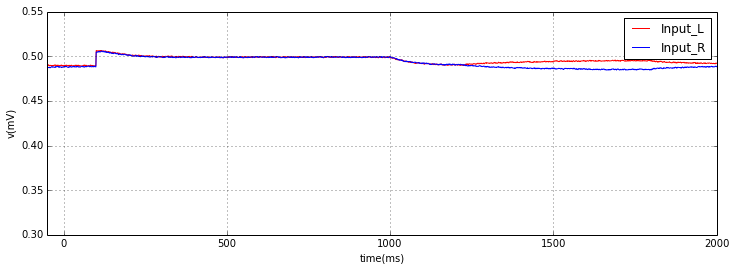

In [13]:

for i in range (0,len(time)-1):
   
    S_L[i+1]=Network_Dynamics(S_L[i],I_L_tot[i],h)
    S_R[i+1]=Network_Dynamics(S_R[i],I_R_tot[i],h)
   
    I_L_tot[i+1] ,I_R_tot[i+1]=total_synaptic_current(S_L[i+1],S_R[i+1],
                                                      I_motion_L[i+1],I_motion_R[i+1],
                                                      I_target[i+1],
                                                      I_noise_L[i+1],I_noise_R[i+1])
fig = plt.figure(figsize=(12,4))
plt.plot(time,I_L_tot,'-',color='red',label='Input_L')
plt.plot(time,I_R_tot,'-',color='blue',label='Input_R')
plt.grid()
plt.xlim((-500,2000))
plt.xlabel('time(ms)')
plt.ylabel('v(mV)')
plt.legend(loc='Best')

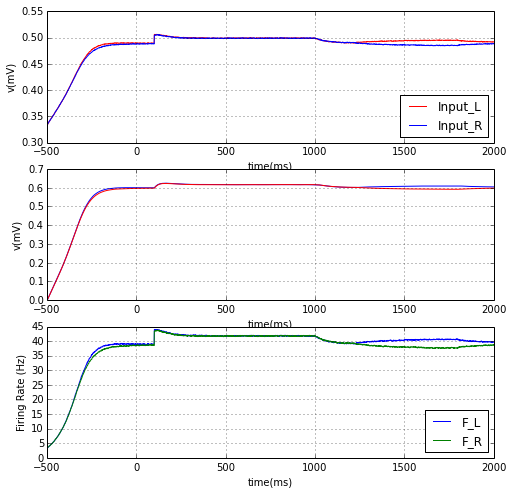

In [11]:
fig = plt.figure(figsize=(8,8))
plt.subplot(311)
plt.plot(time,I_L_tot,'-',color='red',label='Input_L')
plt.plot(time,I_R_tot,'-',color='blue',label='Input_R')
plt.grid()
#plt.xlim((-50,2000))
plt.xlabel('time(ms)')
plt.ylabel('v(mV)')
plt.legend(loc='Best')


plt.subplot(312)
plt.plot(time,S_L,'-',color='blue')
plt.plot(time,S_R,'-',color='red')
plt.grid()
plt.xlabel('time(ms)')
plt.ylabel('v(mV)')

plt.subplot(313)
plt.plot(time,Reduced_Network_Firing(I_L_tot),'-',color='blue',label='F_L')
plt.plot(time,Reduced_Network_Firing(I_R_tot),'-',color='green',label='F_R')
plt.grid()
plt.xlabel('time(ms)')
#plt.ylim((0,60))
plt.ylabel('Firing Rate (Hz)')
plt.legend(loc='Best')
plt.show()
